# Setup

In [113]:
#!pip install mat73

In [17]:
import numpy as np
import scipy.io as sio
import math
import matplotlib.pyplot as plt
from matplotlib import image
import glob
from scipy.stats.stats import pearsonr
import mat73

from sklearn.model_selection import train_test_split
from sklearn.metrics import normalized_mutual_info_score


In [2]:
# which datasets to read and write

do_indian_pines = True 
do_salient_objects = True
do_plastic_flakes = True
do_choledoch_cancer = True

## Define functions

In [4]:
# reward functions

def calculate_correlations(data):
    
    #deal with the first state
    ##### THIS LOGIC SEEMS WRONG - REGARDLESS OF THE FIRST PICK, YOU HAVE A REWARD OF 0#####
    #if np.sum(state) <= 1:
        #return 1
    
    selected_bands = np.random.randint(0,200,30)
    corr_sum = 0
    for i in selected_bands:
        for j in selected_bands:
            
            corr_sum += pearsonr(data[:, i], 
                                 data[:, j])[0]
            
    return corr_sum/(len(selected_bands)**2)


def calculate_mis(data):
    
    #deal with the first state
    ##### THIS LOGIC SEEMS WRONG - REGARDLESS OF THE FIRST PICK, YOU HAVE A REWARD OF 0#####
    #if np.sum(state) <= 1:
        #return 1
        
    # needs to be in ints
    
    selected_bands = np.random.randint(0,200,30)
    normalized_mutual_info_score_sum = 0
    for i in selected_bands:
        for j in selected_bands:
            
            normalized_mutual_info_score_sum += normalized_mutual_info_score(data[:, i],
                                                                             data[:, j])
            
    return normalized_mutual_info_score_sum/(len(selected_bands)**2)


In [120]:
## dataset loading
np.random.seed(seed=42)

def load_datasets(Dataset, write=False):
    
    if Dataset == 'IN':
        data_path = 'land_cover_classification/indian_pines/'
        # data read and reshape
        mat_data = sio.loadmat(data_path + 'Indian_pines_corrected.mat')
        mat_gt = sio.loadmat(data_path + 'Indian_pines_gt.mat')
        data_hsi = mat_data['indian_pines_corrected']
        gt_hsi = mat_gt['indian_pines_gt']
        data = data_hsi.reshape(
            np.prod(data_hsi.shape[:2]), np.prod(data_hsi.shape[2:]))
        gt = gt_hsi.reshape(np.prod(gt_hsi.shape[:2]), )
    
        # remove NA class (label = 0)
        gt = gt[np.where(gt!=0)[0]]
        data = data[np.where(gt!=0)[0], :]
        CLASSES_NUM = len(np.unique(gt))
        
        # train test stratified split
        # x_train, x_test, y_train, y_test = train_test_split(data, 
                                                            #gt,
                                                            #test_size=1-split,
                                                            #random_state=0,
                                                            #stratify=gt)

    if Dataset == 'SO':
        data_path = 'salient_objects_segmentation/HS-SOD/'
        hsi_paths = glob.glob(data_path + 'hyperspectral/*.mat')
        gt_paths = []
        for i in range(len(hsi_paths)):
            num = hsi_paths[i].split('.')[0].split('/')[-1]
            gt_paths.append(data_path + f'ground_truth/{num}.jpg')
            
        # sample 5 paths for experiment
        indices = np.random.randint(0, 60, 5)
        hsi_paths = np.array(hsi_paths)[indices]
        gt_paths = np.array(gt_paths)[indices]
        gt_write_paths = []
        data_write_paths = []
        
        print('\nHypercube write paths...')
        for path in hsi_paths:
            num = path.split('.')[0].split('/')[-1]
            data_write_tmp = f'../HyperSpectralRL/data/salient_objects/hyperspectral_imagery/{num}.npy'
            data_write_paths.append(data_write_tmp)
            print(f'Saving {path} to  ->  {data_write_tmp}')     
        
        print('\nLabel write paths...')
        for path in gt_paths:
            num = path.split('.')[0].split('/')[-1]
            gt_write_tmp = f'../HyperSpectralRL/data/salient_objects/gt_labels/{num}.npy'
            gt_write_paths.append(gt_write_tmp)            
            print(f'Saving {path} to  ->  {gt_write_tmp}')
            
        # read samples
        data = []
        data_hsi = []
        gt_hsi = []
        gt = []
        for path in hsi_paths:
            mat_data = mat73.loadmat(path)  
            mat_data = mat_data['hypercube'].astype(np.uint8)
            data_hsi.append(mat_data)
            data_tmp = mat_data.reshape(
                np.prod(mat_data.shape[:2]), np.prod(mat_data.shape[2:]))
            data.append(data_tmp)
            
        for path in gt_paths:
            label_mask = image.imread(path)
            gt_hsi.append(label_mask[:,:,0])
            gt_tmp = label_mask[:,:,0].reshape(np.prod(label_mask[:,:,0].shape[:2]), )
            gt_tmp[gt_tmp!=0] = 1
            gt.append(gt_tmp.astype(np.uint8))
        
        if write:
            for itr, img in enumerate(data):
                np.save(data_write_paths[itr], img)
            for itr, img in enumerate(gt):
                np.save(gt_write_paths[itr], img)
                
    if Dataset == 'PF':
        data_path = 'plastic_flakes_segmentation/HSOD-ICIP-2022/baselines_cropped/training/'
        hsi_paths = glob.glob(data_path + 'crop/*.npz')
        gt_paths = []
        for i in range(len(hsi_paths)):
            num = hsi_paths[i].split('.')[0].split('/')[-1]
            gt_paths.append(data_path + f'annot/{num}.npy')
            
        print(hsi_paths[-1])
        print(gt_paths[-1])
        
    if Dataset == 'CD':
        data_path = 'cancer_cell_detection/L/'
        hsi_paths = glob.glob(data_path + 'hyper/*.raw')
        gt_paths = []
        for i in range(len(hsi_paths)):
            num = hsi_paths[i].split('.')[0].split('/')[-1]
            gt_paths.append(data_path + f'annotation/{num}.xml')
            
        print(hsi_paths[-1])
        print(gt_paths[-1])
        
    return data_hsi, gt_hsi, data, gt

# add write paths for gt / data upon return



In [121]:
if do_salient_objects:
    data_hsi, gt_hsi, data, gt = load_datasets(
        'SO', write=True)
    
    print('\nDataset info...')
    print('The shape of the original imagery:', data_hsi[0].shape)
    print('The shape of the original labels:', gt_hsi[0].shape)
    print('The shape of the flattened imagery:', data[0].shape)
    print('The shape of the flattened labels:', gt[0].shape)
    print('The number of different classes:', len(np.unique(gt[0])))


Hypercube write paths...
Saving salient_objects_segmentation/HS-SOD/hyperspectral/0051.mat to  ->  ../HyperSpectralRL/data/salient_objects/hyperspectral_imagery/0051.npy
Saving salient_objects_segmentation/HS-SOD/hyperspectral/0037.mat to  ->  ../HyperSpectralRL/data/salient_objects/hyperspectral_imagery/0037.npy
Saving salient_objects_segmentation/HS-SOD/hyperspectral/0082.mat to  ->  ../HyperSpectralRL/data/salient_objects/hyperspectral_imagery/0082.npy
Saving salient_objects_segmentation/HS-SOD/hyperspectral/0077.mat to  ->  ../HyperSpectralRL/data/salient_objects/hyperspectral_imagery/0077.npy
Saving salient_objects_segmentation/HS-SOD/hyperspectral/0052.mat to  ->  ../HyperSpectralRL/data/salient_objects/hyperspectral_imagery/0052.npy

Label write paths...
Saving salient_objects_segmentation/HS-SOD/ground_truth/0051.jpg to  ->  ../HyperSpectralRL/data/salient_objects/gt_labels/0051.npy
Saving salient_objects_segmentation/HS-SOD/ground_truth/0037.jpg to  ->  ../HyperSpectralRL/dat

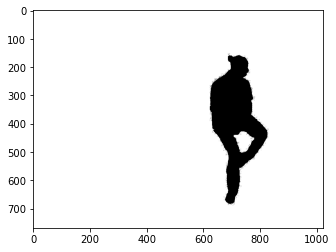

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [110]:
np.unique(gt[0])
plt.imshow(gt[0].reshape([768, 1024]), cmap='Greys')
plt.show()
plt.figure()

In [78]:
gt_hsi[-1].shape

(768, 1024)

In [43]:
if do_plastic_flakes:
    load_datasets(
        'PF')
    

plastic_flakes_segmentation/HSOD-ICIP-2022/baselines_cropped/training/crop/try_8_1.npz
plastic_flakes_segmentation/HSOD-ICIP-2022/baselines_cropped/training/annot/try_8_1.npy


In [44]:
if do_choledoch_cancer:
    load_datasets(
        'CD')
    

cancer_cell_detection/L/hyper/042145-20x-roi10.raw
cancer_cell_detection/L/annotation/042145-20x-roi10.xml


The shape of the original imagery: (145, 145, 200)
The shape of the original labels: (145, 145) 

The shape of the flattened imagery: (10249, 200)
The shape of the flattened labels: (10249,)
The number of different classes: 16


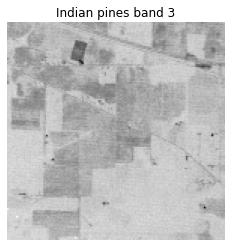

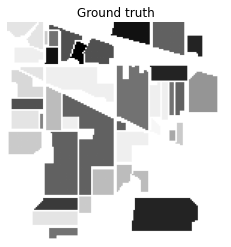


Correlation reward for random 30 bands, x20 runs: 0.4729762710246493
Normalized mutual information reward for random 30 bands, x20 runs: 0.5774787106580945


<Figure size 432x288 with 0 Axes>

In [63]:
if do_indian_pines:
    
    data_hsi, gt_hsi, data, gt = load_datasets(
        'IN')
    
    print('The shape of the original imagery:', data_hsi.shape)
    print('The shape of the original labels:', gt_hsi.shape, '\n')
    print('The shape of the flattened imagery:', data.shape)
    print('The shape of the flattened labels:', gt.shape)
    print('The number of different classes:', len(np.unique(gt)))
    
    # plot a sample band
    plt.imshow(data_hsi[:,:,3]/np.max(data_hsi[:,:,3]*255), cmap='Greys')
    plt.title(f'Indian pines band 3')
    plt.axis("off")
    plt.show()
    plt.figure()
    # plot the labels
    plt.imshow(gt_hsi, cmap='Greys')
    plt.title(f'Ground truth')
    plt.axis("off")
    plt.show()
    plt.figure()
    
    # rewards
    correlations = []
    for i in range(20):
        correlations.append(calculate_correlations(data))
    print('\nCorrelation reward for random 30 bands, x20 runs:', np.mean(correlations))
    
    mis = []
    for i in range(20):
        mis.append(calculate_mis(data))
    print('Normalized mutual information reward for random 30 bands, x20 runs:', np.mean(mis))    
    